In [1]:
from pynhd import AGRBase, NLDI
from pygeohydro import NWIS
import geopandas as gpd
import numpy as np
import ujson as json
import pandas as pd
import warnings
from rio_tiler.io import COGReader
import proplot

In [2]:
warnings.filterwarnings("ignore", message=".*rio-tiler performances.*")

In [3]:
def population_agg(geo_df: gpd.GeoDataFrame) -> pd.DataFrame:
    """Get population within a dataframe of polygons from Facebook's HRSL.
    
    HRSL estimates the number of people living within 30-meter grid.
    """
    HRSL = "/".join(["https://dataforgood-fb-data.s3.amazonaws.com","hrsl-cogs/hrsl_general/hrsl_general-latest.vrt"])

    with COGReader(HRSL) as cog:
        gdf = geo_df.to_crs(cog.dataset.crs)
        pop = pd.DataFrame.from_dict(
            {
                feat["id"]: np.nansum(cog.feature(feat, dst_crs=cog.dataset.crs).data)
                for feat in json.loads(gdf.geometry.to_json())["features"]
            },
            orient="index",
        )
        pop.index = pop.index.astype(int)

    return pop

In [4]:
def catchments(station: str) -> gpd.GeoDataFrame:
    """Get catchments for a USGS station."""
    nldi = NLDI()
    nwis = NWIS()

    info = nwis.get_info({"site": station})
    coords = (info.dec_long_va.iloc[0], info.dec_lat_va.iloc[0])
    trib = nldi.navigate_byloc(coords, "upstreamTributaries", "flowlines")
    trib = trib.set_index("nhdplus_comid")

    url = "https://watersgeo.epa.gov/arcgis/rest/services/NHDPlus/NHDPlus/MapServer"
    epa = AGRBase(url, layer="catchment")
    wb = epa.byids("FEATUREID", trib.index.to_list())
    wb.columns = [c.lower() for c in wb.columns]
    return wb.set_index("featureid")

In [5]:
wb = catchments("08075000")
wb["population"] = population_agg(wb)

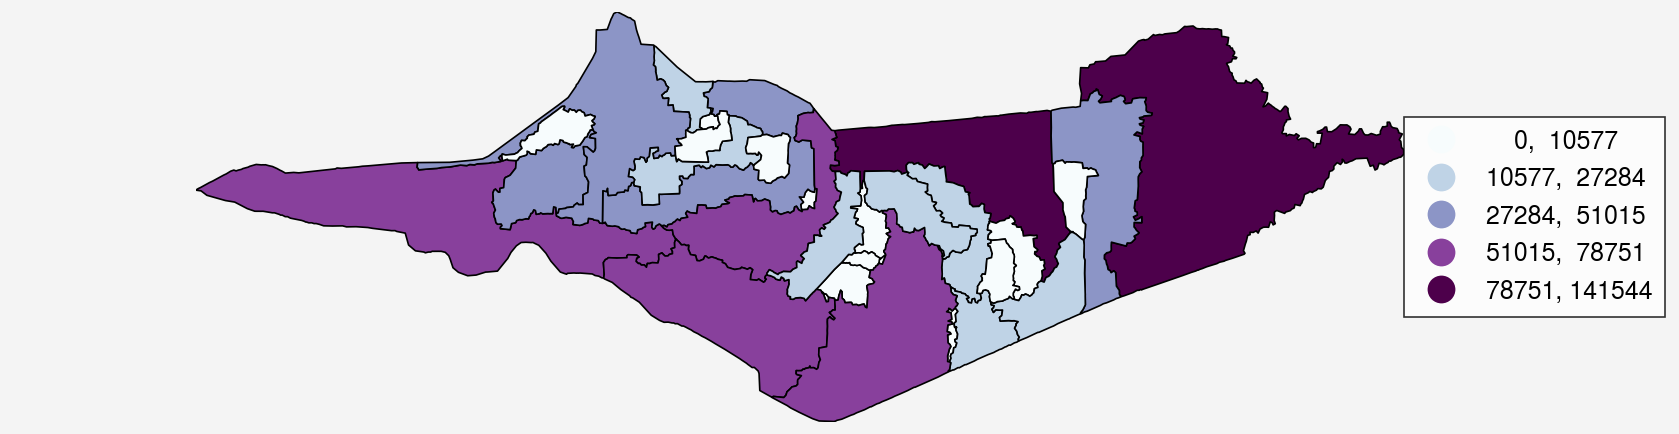

In [7]:
_, ax = proplot.subplots(refwidth=8)
ax.format
wb.plot(
    ax=ax,
    column="population",
    scheme='FisherJenks',
    k=5,
    cmap='BuPu',
    edgecolor='k',
    legend=True,
    legend_kwds={
        'loc': 'center left', 'bbox_to_anchor':(1,0.5),  'fmt':"{:.0f}", "ncol": 1
    },
)
ax.set_axis_off()
ax.margins(0)